#### Imports Block

In [96]:
# -- IMPORTS START --
import pandas as pd
import glob
import re
import os
import sys
import pickle
import datetime
import numpy as np
import matplotlib.pyplot as plt


from datetime import datetime
from sklearn import tree, metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import train_test_split
# -- IMPORTS END --

# enable zooming into graphs
%matplotlib notebook
plt.rcParams['figure.figsize'] = [9, 6] # width, height in inches

#### Raw Signal Plots

Our plots before data pre processing

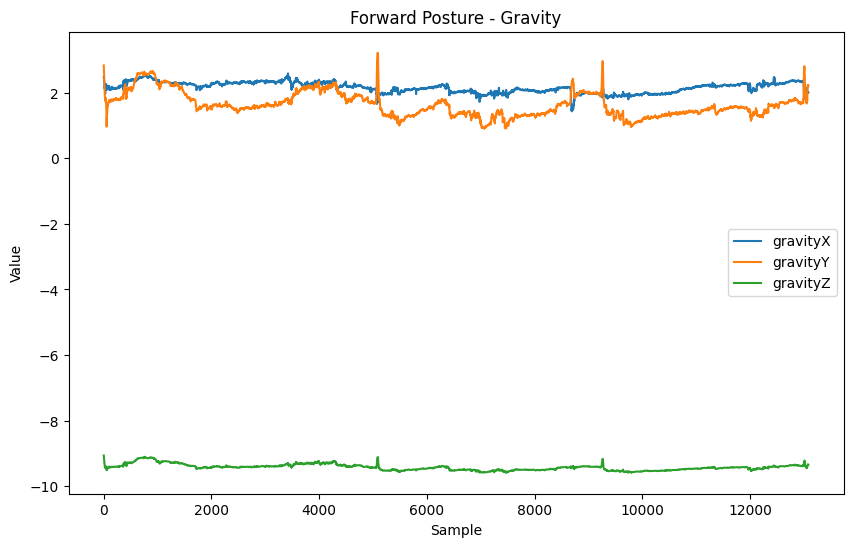

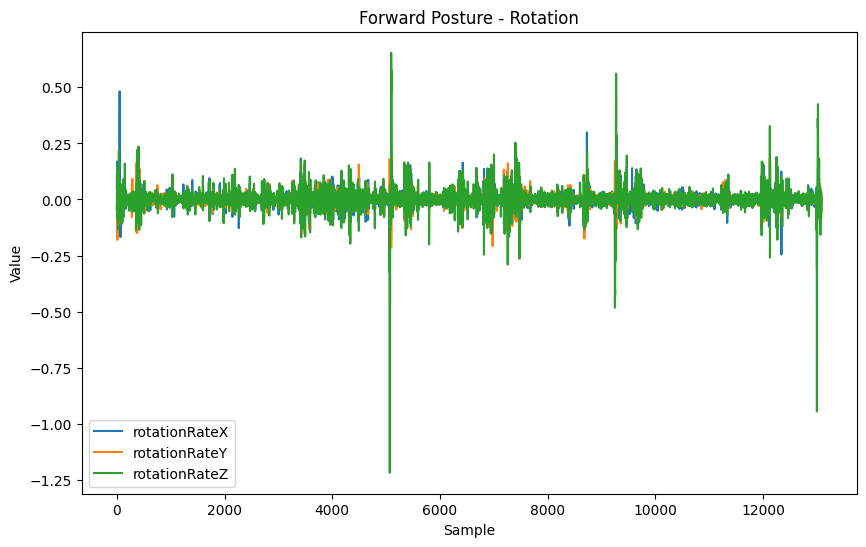

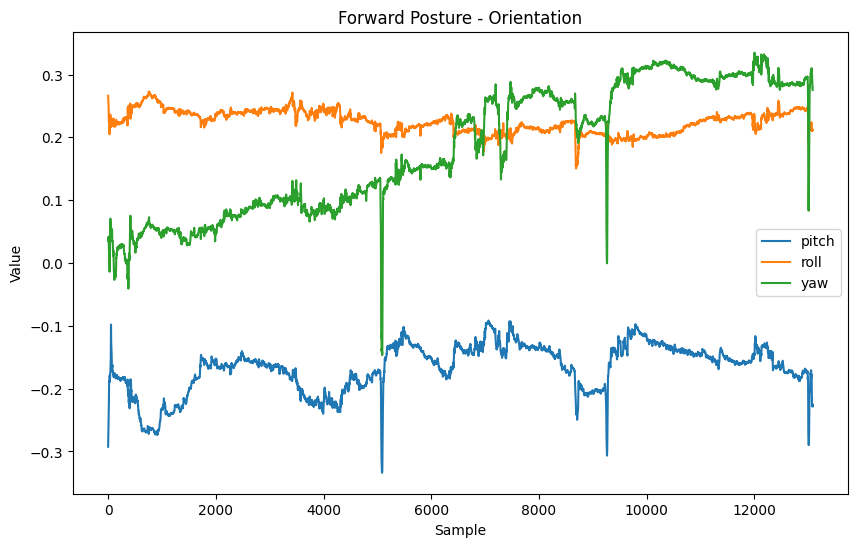

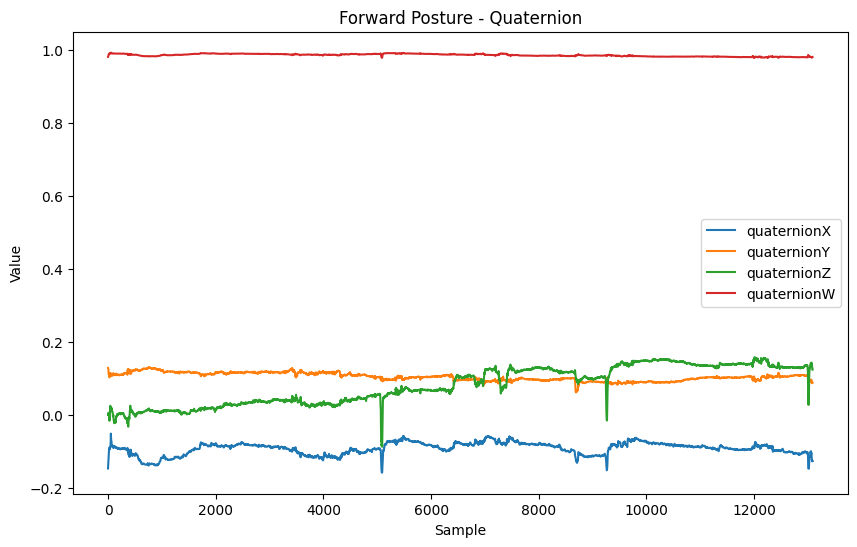

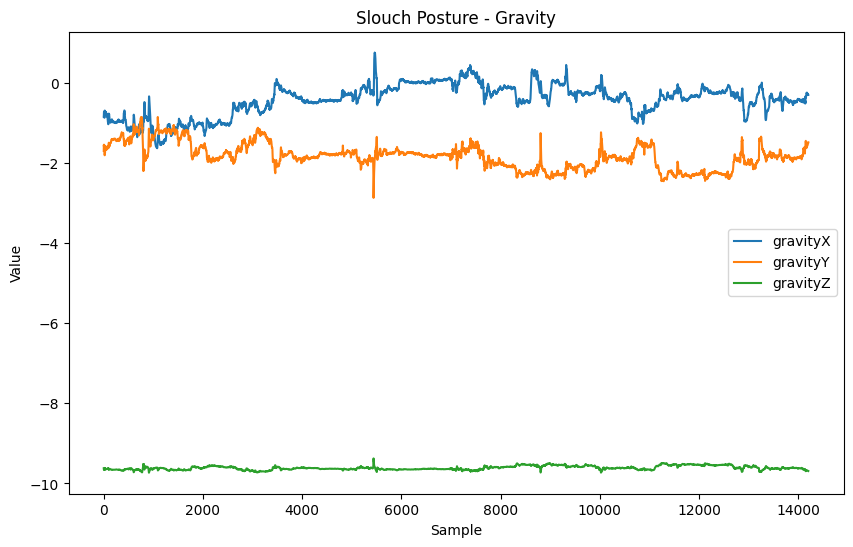

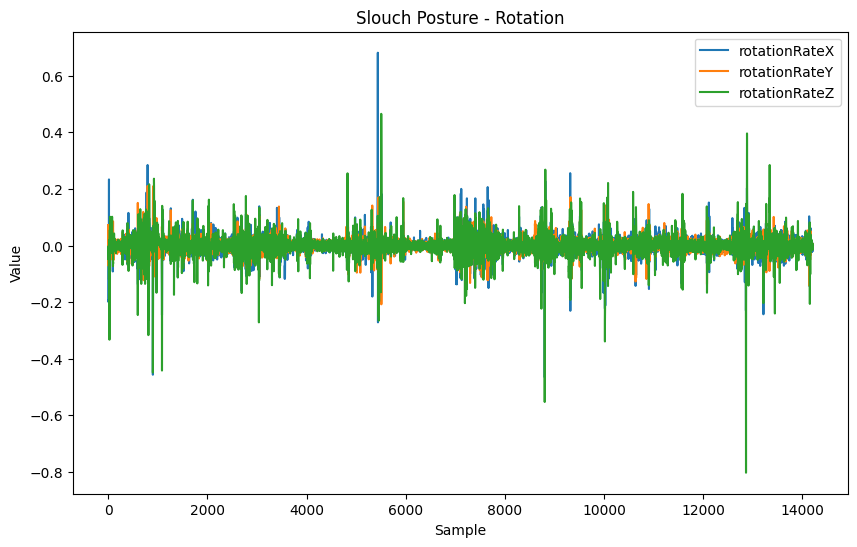

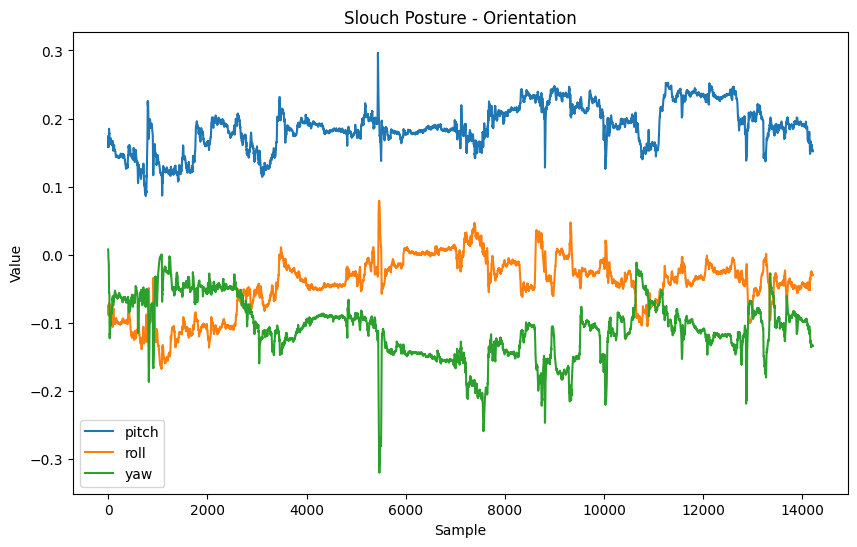

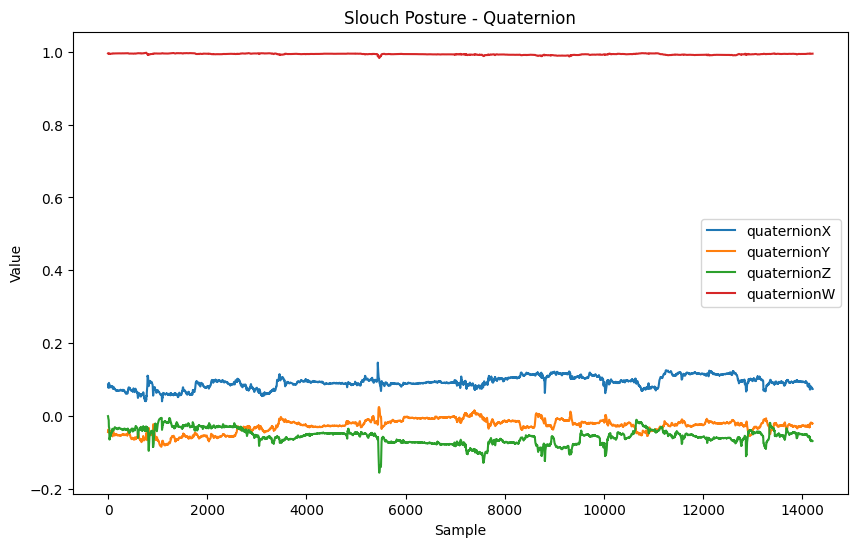

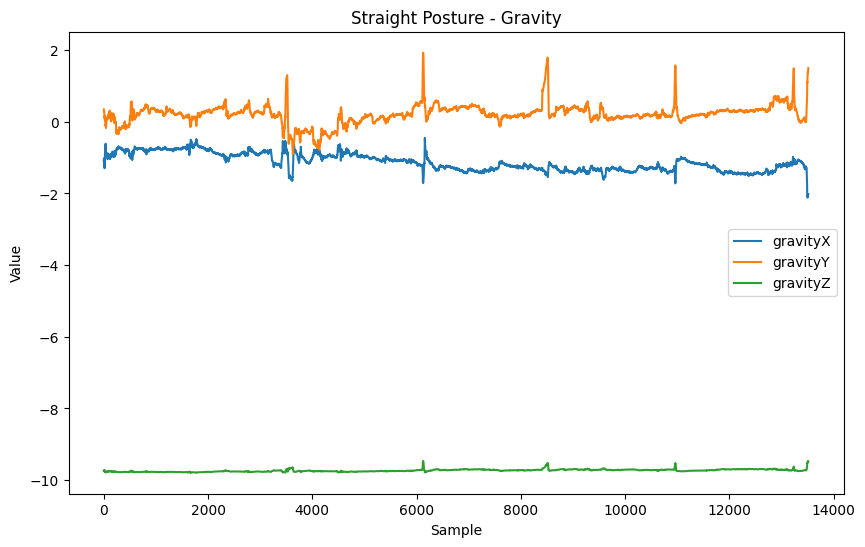

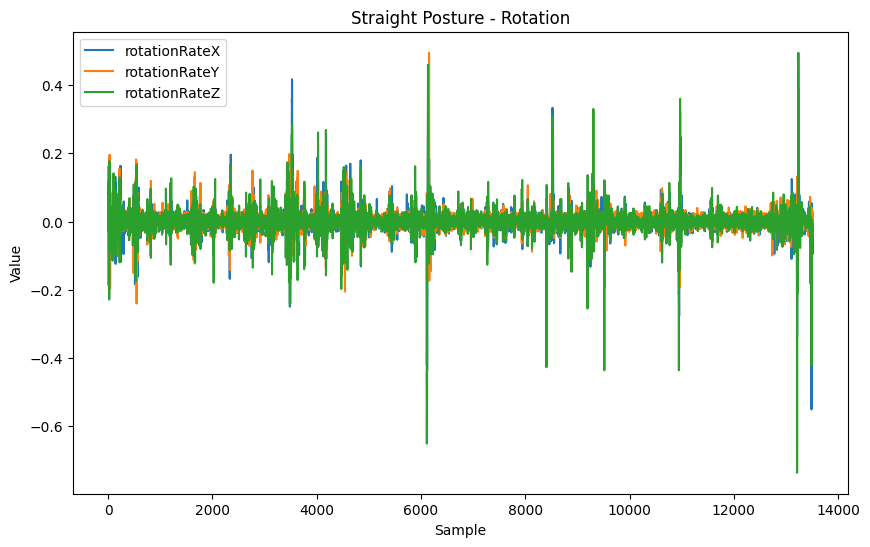

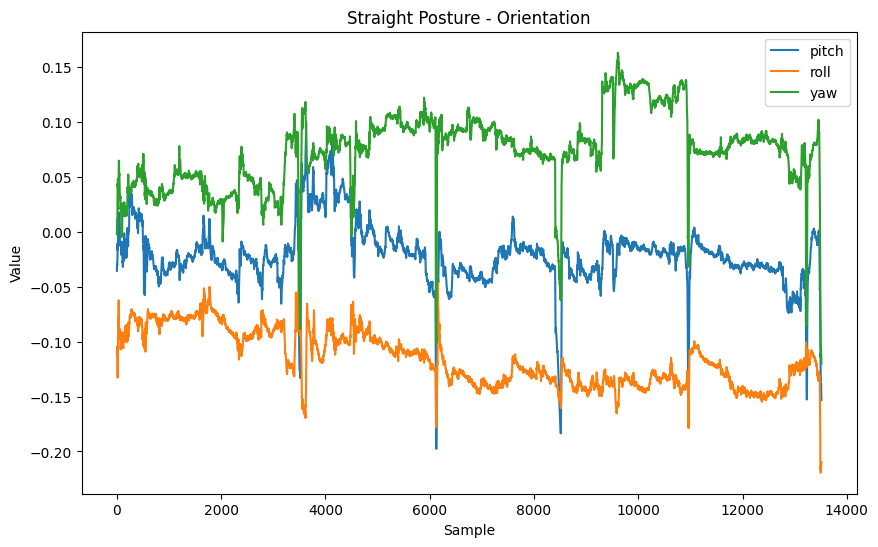

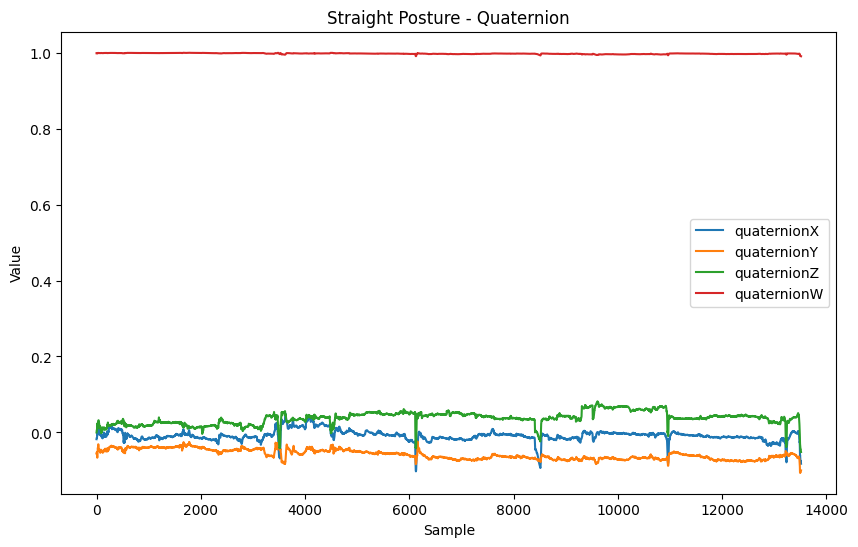

In [97]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt

# Ensure plots are displayed inline
%matplotlib inline

# Open the files
forward_data = pd.read_csv('Data/Forward/Arnav_forward5.csv')
slouch_data = pd.read_csv('Data/Slouch/Arnav_slouch1.csv')
straight_data = pd.read_csv('Data/Straight/Arnav_straight6.csv')

# Function to plot data
def plot_data(data, columns, title):
    plt.figure(figsize=(10, 6))
    for column in columns:
        plt.plot(data[column], label=column)
    plt.title(title)
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

plot_data(forward_data, ['gravityX', 'gravityY', 'gravityZ'], 'Forward Posture - Gravity')
plot_data(forward_data, ['rotationRateX', 'rotationRateY', 'rotationRateZ'], 'Forward Posture - Rotation')
plot_data(forward_data, ['pitch', 'roll', 'yaw'], 'Forward Posture - Orientation')
plot_data(forward_data, ['quaternionX', 'quaternionY', 'quaternionZ', 'quaternionW'], 'Forward Posture - Quaternion')

plot_data(slouch_data, ['gravityX', 'gravityY', 'gravityZ'], 'Slouch Posture - Gravity')
plot_data(slouch_data, ['rotationRateX', 'rotationRateY', 'rotationRateZ'], 'Slouch Posture - Rotation')
plot_data(slouch_data, ['pitch', 'roll', 'yaw'], 'Slouch Posture - Orientation')
plot_data(slouch_data, ['quaternionX', 'quaternionY', 'quaternionZ', 'quaternionW'], 'Slouch Posture - Quaternion')

plot_data(straight_data, ['gravityX', 'gravityY', 'gravityZ'], 'Straight Posture - Gravity')
plot_data(straight_data, ['rotationRateX', 'rotationRateY', 'rotationRateZ'], 'Straight Posture - Rotation')
plot_data(straight_data, ['pitch', 'roll', 'yaw'], 'Straight Posture - Orientation')
plot_data(straight_data, ['quaternionX', 'quaternionY', 'quaternionZ', 'quaternionW'], 'Straight Posture - Quaternion')

#### Transform DateTime

In [98]:
import os
import glob
import pandas as pd

def transform_time_to_datetime(root):
    dateparse = lambda dates: [pd.to_datetime(d, unit='ns') for d in dates]
    # Get list of all activity folders
    activity_folders = os.listdir(root)
    # print(activity_folders)

    for folder in activity_folders:
        # print(folder)
        files = glob.glob(f"{root}/{folder}/*.csv")
        for filename in files:
            # print(filename)
            df = pd.read_csv(filename, parse_dates=['time'])
            df['time'] = pd.to_datetime(pd.to_numeric(df['time']), unit='ns')
            df.to_csv(filename, index=False)

# Call the function on all files in the Data folder
transform_time_to_datetime('Data')

#### Data preprocessing

Applying filters: low pass filter and moving average. 
Further preprocessing by trimming first and last 5 seconds 

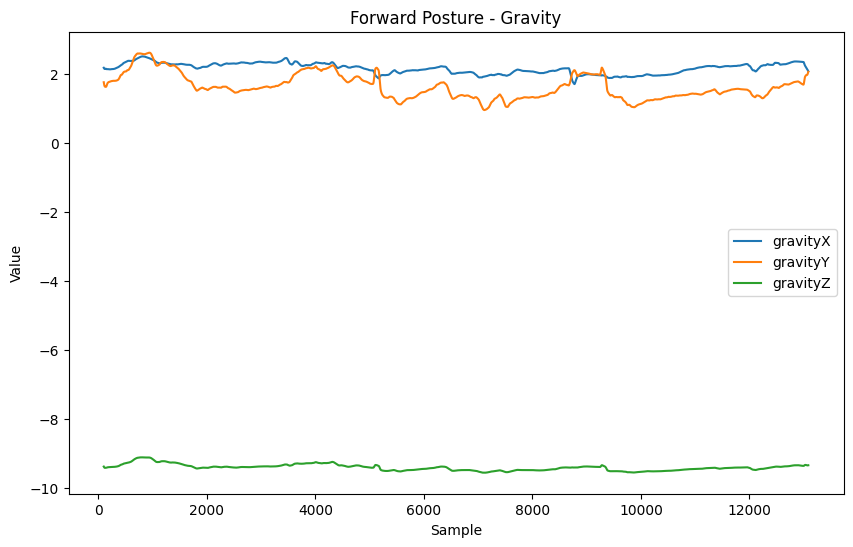

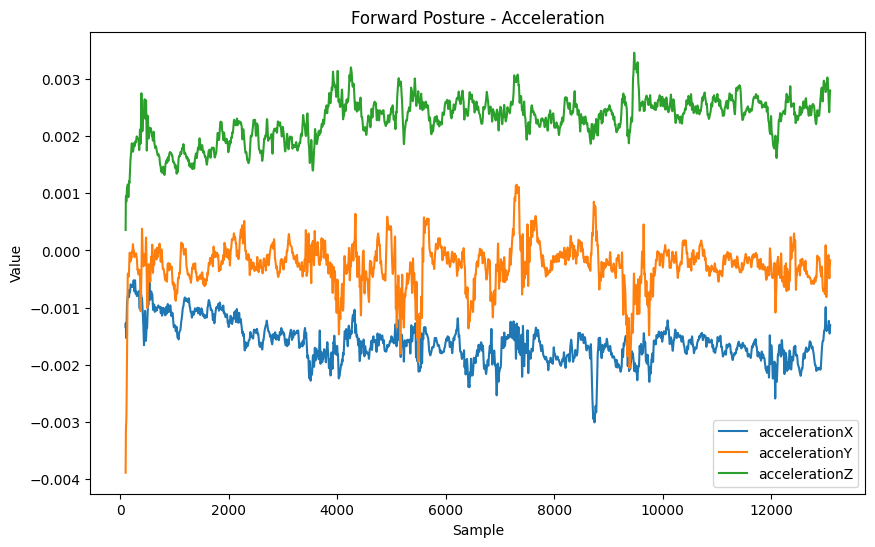

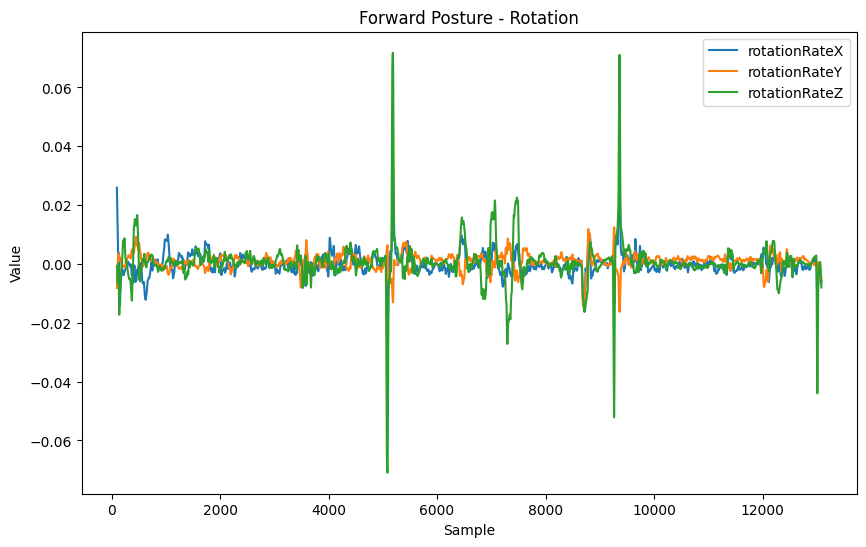

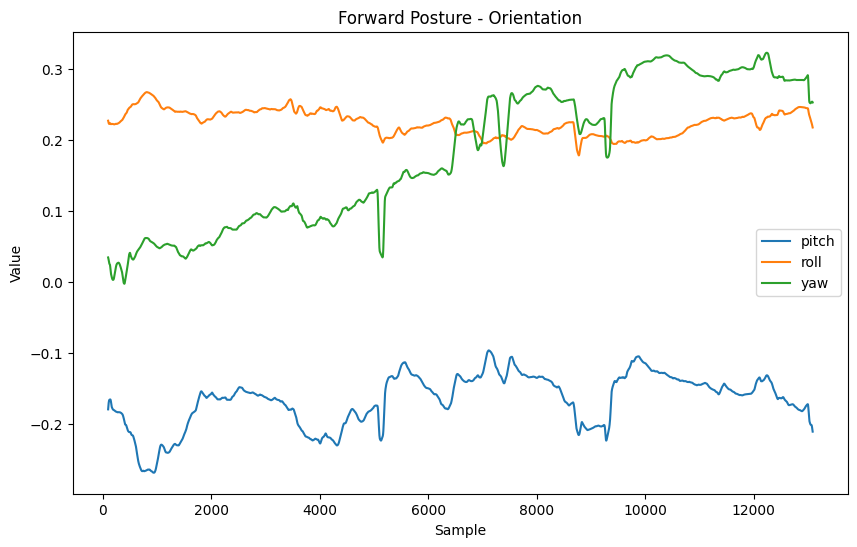

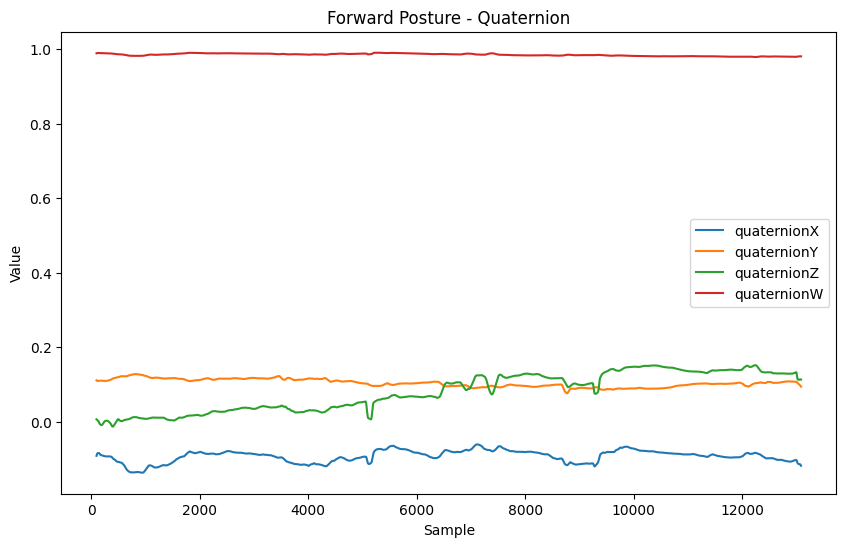

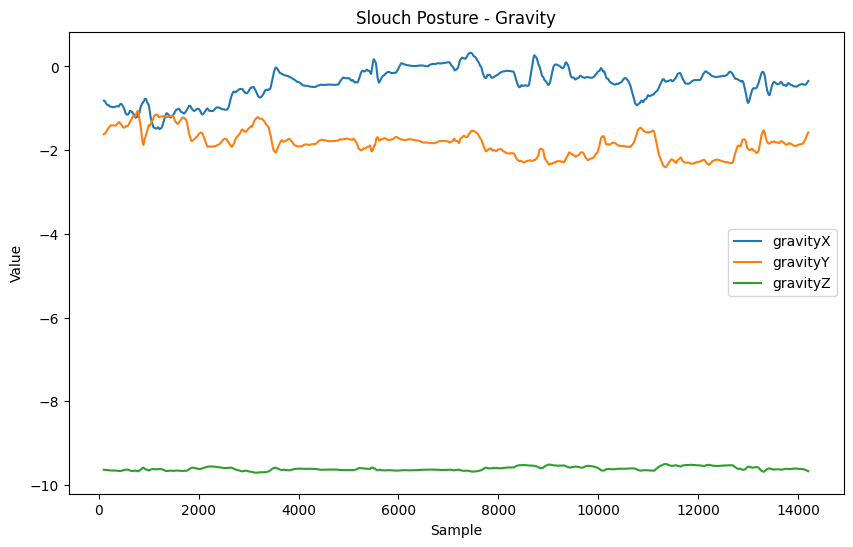

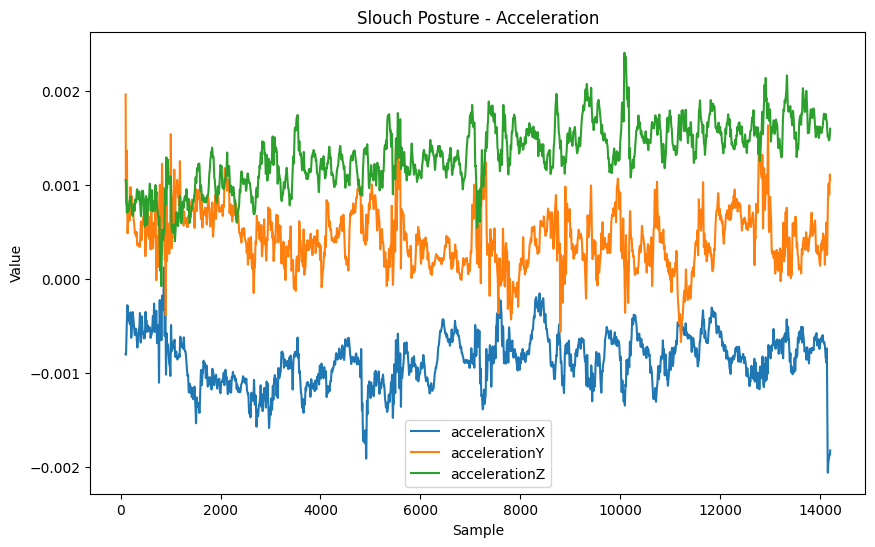

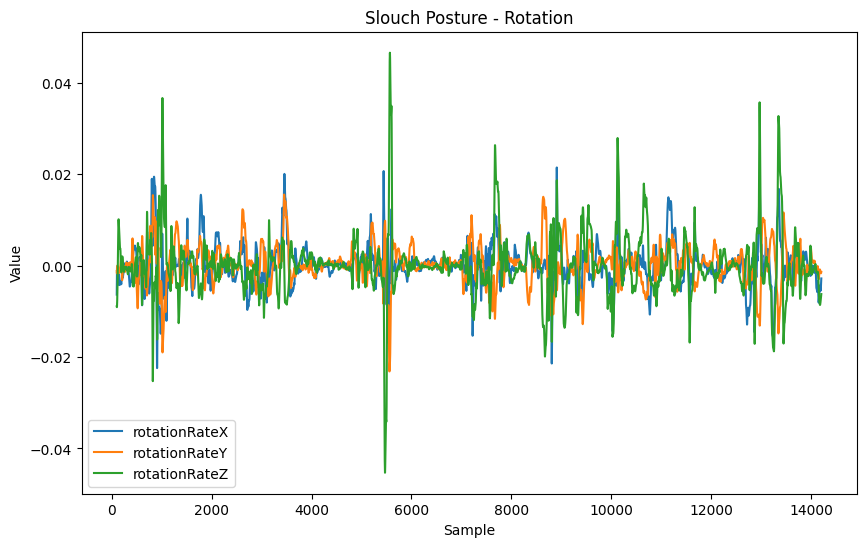

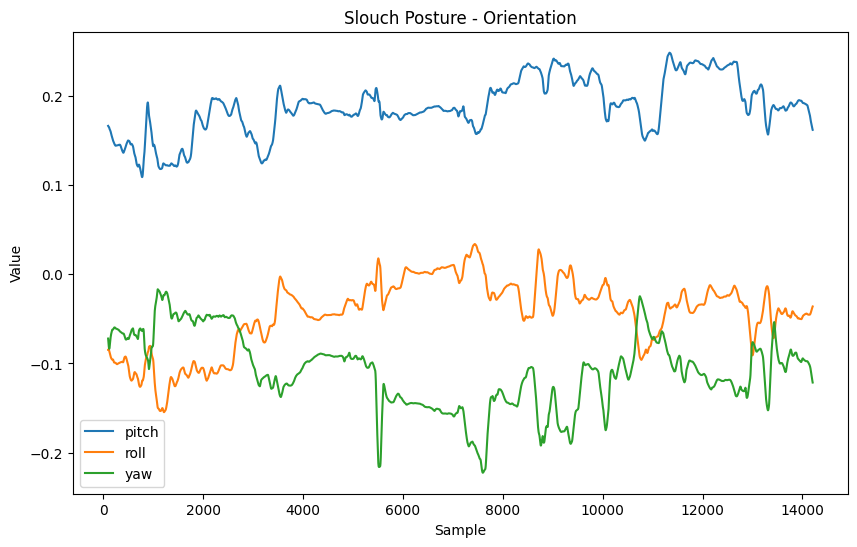

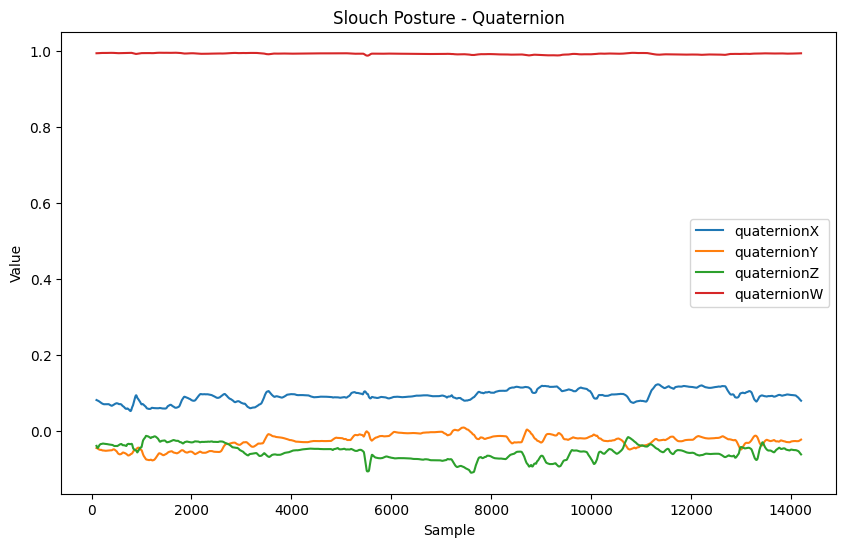

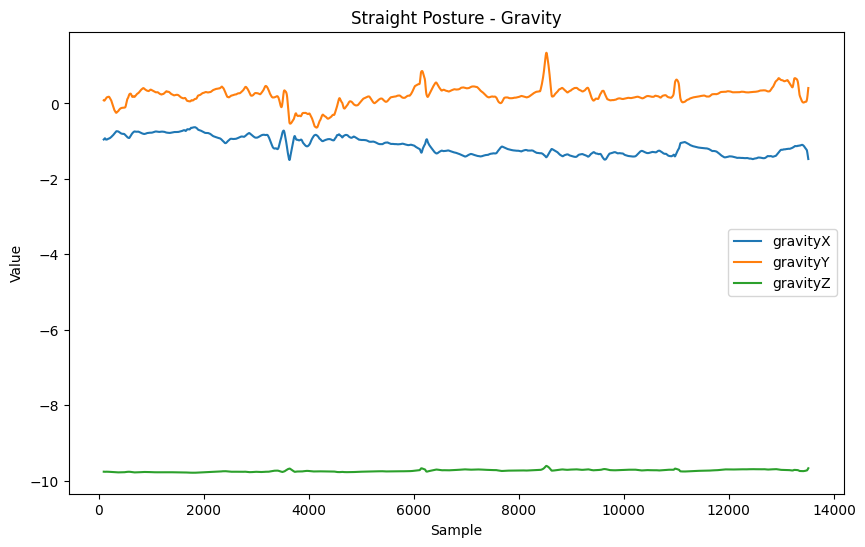

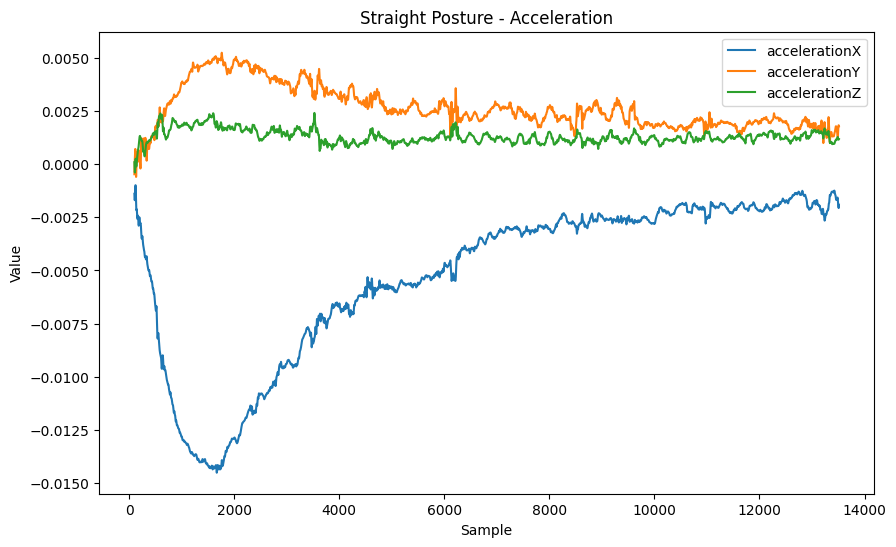

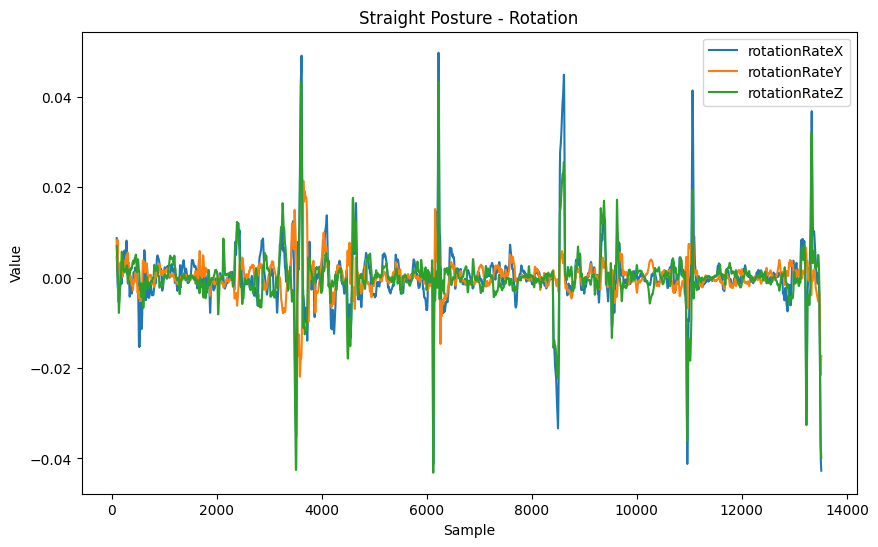

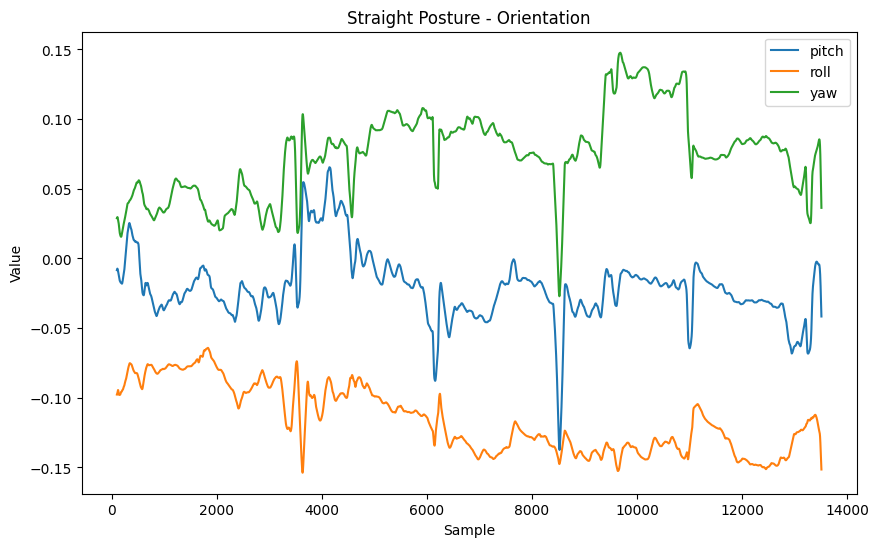

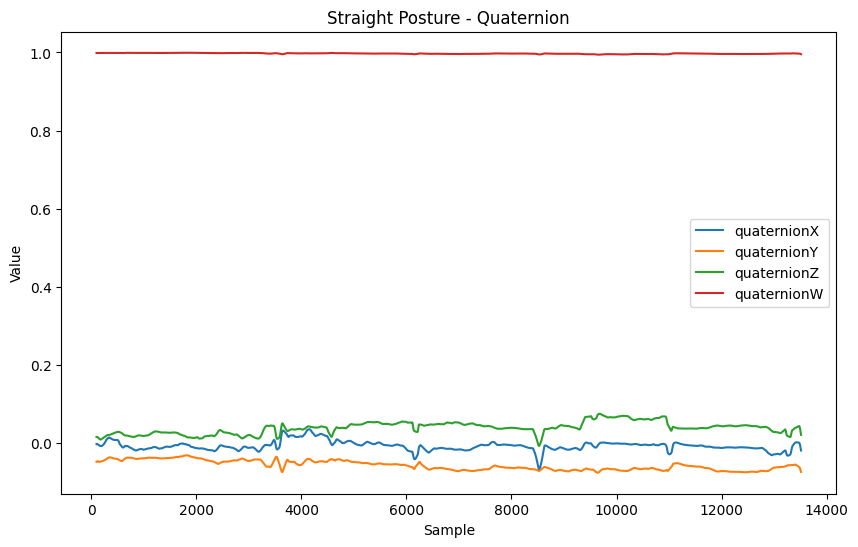

In [118]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Ensure plots are displayed inline
%matplotlib inline

# Define a function to apply a low-pass filter
def low_pass_filter(data, cutoff=5, fs=100, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Define a function to apply a moving average filter
def moving_average_filter(data, window_size=100):
    return data.rolling(window=window_size).mean()

# Define a function to remove the first and last 5 seconds of data
def trim_data(data, fs=100, seconds=5):
    samples_to_trim = fs * seconds
    return data.iloc[samples_to_trim:-samples_to_trim]

# Open the files
forward_data = pd.read_csv('Data/Forward/Arnav_forward5.csv')
slouch_data = pd.read_csv('Data/Slouch/Arnav_slouch1.csv')
straight_data = pd.read_csv('Data/Straight/Arnav_straight6.csv')

# Apply the filters and trim the data
for data in [forward_data, slouch_data, straight_data]:
    for column in ['accelerationX', 'accelerationY', 'accelerationZ', 'gravityX', 'gravityY', 'gravityZ', 'rotationRateX', 'rotationRateY', 'rotationRateZ', 'pitch', 'roll', 'yaw', 'quaternionX', 'quaternionY', 'quaternionZ', 'quaternionW']:
        if column in data.columns:
            data[column] = low_pass_filter(data[column])
            data[column] = moving_average_filter(data[column])
    data = trim_data(data)

# Function to plot data
def plot_data(data, columns, title):
    plt.figure(figsize=(10, 6))
    for column in columns:
        plt.plot(data[column], label=column)
    plt.title(title)
    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Draw plots for gravity, rotation, orientation, and quaternion data
plot_data(forward_data, ['gravityX', 'gravityY', 'gravityZ'], 'Forward Posture - Gravity')
plot_data(forward_data, ['accelerationX', 'accelerationY', 'accelerationZ'], 'Forward Posture - Acceleration')
plot_data(forward_data, ['rotationRateX', 'rotationRateY', 'rotationRateZ'], 'Forward Posture - Rotation')
plot_data(forward_data, ['pitch', 'roll', 'yaw'], 'Forward Posture - Orientation')
plot_data(forward_data, ['quaternionX', 'quaternionY', 'quaternionZ', 'quaternionW'], 'Forward Posture - Quaternion')

plot_data(slouch_data, ['gravityX', 'gravityY', 'gravityZ'], 'Slouch Posture - Gravity')
plot_data(slouch_data, ['accelerationX', 'accelerationY', 'accelerationZ'], 'Slouch Posture - Acceleration')
plot_data(slouch_data, ['rotationRateX', 'rotationRateY', 'rotationRateZ'], 'Slouch Posture - Rotation')
plot_data(slouch_data, ['pitch', 'roll', 'yaw'], 'Slouch Posture - Orientation')
plot_data(slouch_data, ['quaternionX', 'quaternionY', 'quaternionZ', 'quaternionW'], 'Slouch Posture - Quaternion')

plot_data(straight_data, ['gravityX', 'gravityY', 'gravityZ'], 'Straight Posture - Gravity')
plot_data(straight_data, ['accelerationX', 'accelerationY', 'accelerationZ'], 'Straight Posture - Acceleration')
plot_data(straight_data, ['rotationRateX', 'rotationRateY', 'rotationRateZ'], 'Straight Posture - Rotation')
plot_data(straight_data, ['pitch', 'roll', 'yaw'], 'Straight Posture - Orientation')
plot_data(straight_data, ['quaternionX', 'quaternionY', 'quaternionZ', 'quaternionW'], 'Straight Posture - Quaternion')

#### Raw Signal Plots

Feature extraction and creating combined CSV file 

In [100]:
import os
import glob
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt


def low_pass_filter(data, cutoff=5, fs=100, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

def moving_average_filter(data, window_size=20):
    return data.rolling(window=window_size).mean()


def trim_data(data, fs=100, seconds=5):
    samples_to_trim = fs * seconds
    return data.iloc[samples_to_trim:-samples_to_trim]

def calculate_magnitude(data, columns):
    return np.sqrt(np.sum(np.square(data[columns]), axis=1))

def add_features(window):
    features = pd.Series()
    
    features['acceleration_magnitude_mean'] = calculate_magnitude(window, ['accelerationX', 'accelerationY', 'accelerationZ']).mean()
    features['acceleration_magnitude_std'] = calculate_magnitude(window, ['accelerationX', 'accelerationY', 'accelerationZ']).std()
    
    for column in window.columns:
        if column != 'devicelocation' and column != 'time' and column != 'seconds_elapsed':
            features[f'{column}_mean'] = window[column].mean()
            features[f'{column}_std'] = window[column].std()
    
    return features

def extract_features(data, window_sec, sample_rate, activity):
    window_size = window_sec * sample_rate
    features_list = []
    
    for start in range(0, len(data) - window_size + 1, window_size):
        window = data.iloc[start:start + window_size]
        features = add_features(window)
        features['activity'] = activity
        features_list.append(features)
    
    features_df = pd.DataFrame(features_list)
    
    return features_df

def all_data_to_combined_csv(root, output_filename='all_data.csv', window_sec=60, sample_rate=25):
    all_data = pd.DataFrame()
    csv_files = glob.glob(os.path.join(root, '**', '*.csv'), recursive=True)

    for file in csv_files:
        data = pd.read_csv(file)
        
        for column in ['accelerationX', 'accelerationY', 'accelerationZ', 'gravityX', 'gravityY', 'gravityZ', 'rotationRateX', 'rotationRateY', 'rotationRateZ', 'pitch', 'roll', 'yaw', 'quaternionX', 'quaternionY', 'quaternionZ', 'quaternionW']:
            if column in data.columns:
                data[column] = low_pass_filter(data[column])
                data[column] = moving_average_filter(data[column])
        data = trim_data(data)
        
        activity = os.path.basename(os.path.dirname(file))
        
        features = extract_features(data, window_sec, sample_rate, activity)
        all_data = pd.concat([all_data, features], ignore_index=True)

    all_data.to_csv(os.path.join(root, output_filename), index=False)
    print(f"Combined CSV file created at: {os.path.join(root, output_filename)}")

# Call the function to combine all data into a single CSV file
all_data_to_combined_csv('Data')

Combined CSV file created at: Data/all_data.csv


Best Parameters: {'max_depth': 10, 'n_estimators': 150}
Test Accuracy: 0.9444444444444444
Confusion Matrix:
[[31  0  0]
 [ 4 26  2]
 [ 0  0 45]]
Classification Report:
              precision    recall  f1-score   support

     Forward       0.89      1.00      0.94        31
      Slouch       1.00      0.81      0.90        32
    Straight       0.96      1.00      0.98        45

    accuracy                           0.94       108
   macro avg       0.95      0.94      0.94       108
weighted avg       0.95      0.94      0.94       108



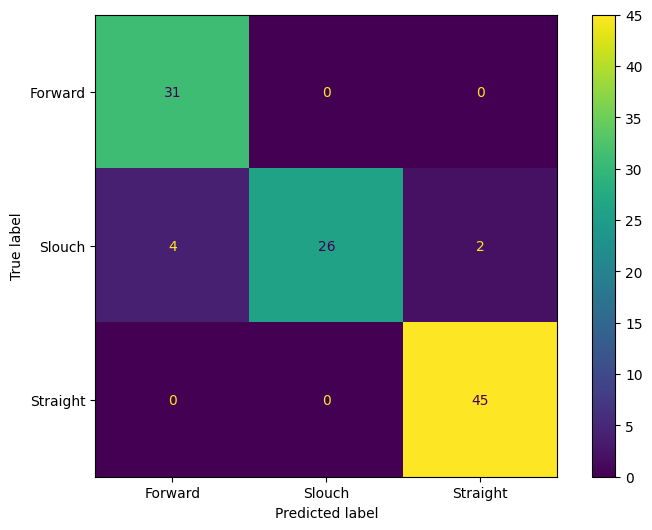

Top important features:
quaternionX_mean: 0.15182092471001601
gravityY_mean: 0.13366143004718295
pitch_mean: 0.1292406137935875
gravityZ_mean: 0.09451876499667759
gravityX_mean: 0.07543969602928122
roll_mean: 0.06076633356931853
quaternionY_mean: 0.05766149270046476
accelerationZ_mean: 0.02930398822051984
acceleration_magnitude_mean: 0.028360183104668382
gravityZ_std: 0.02480942660415321


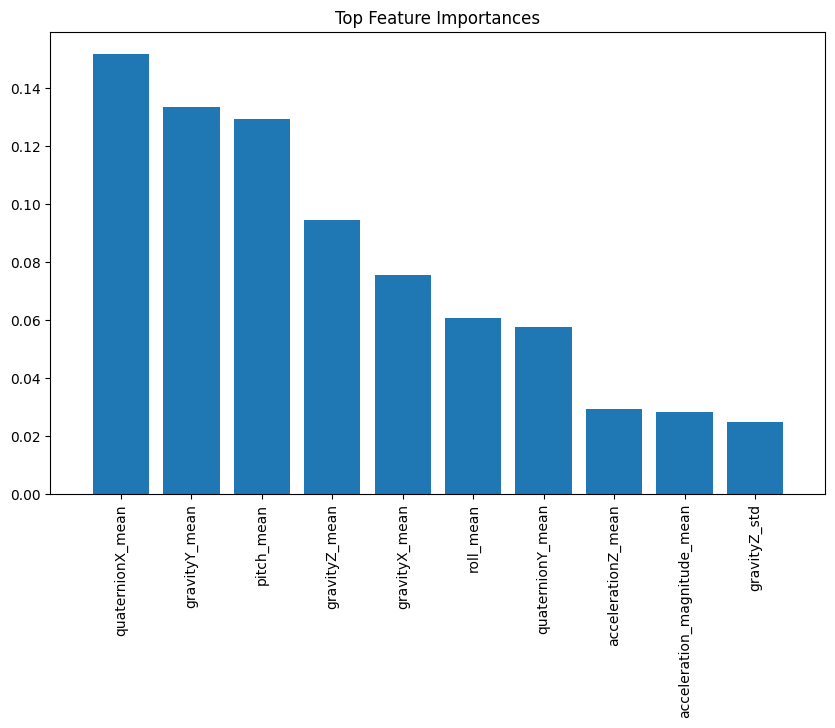

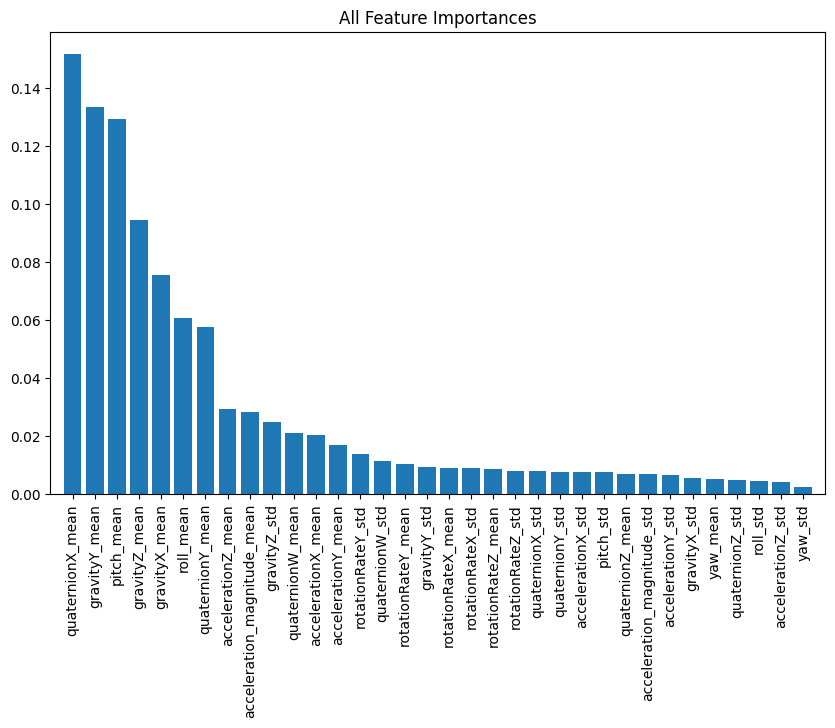

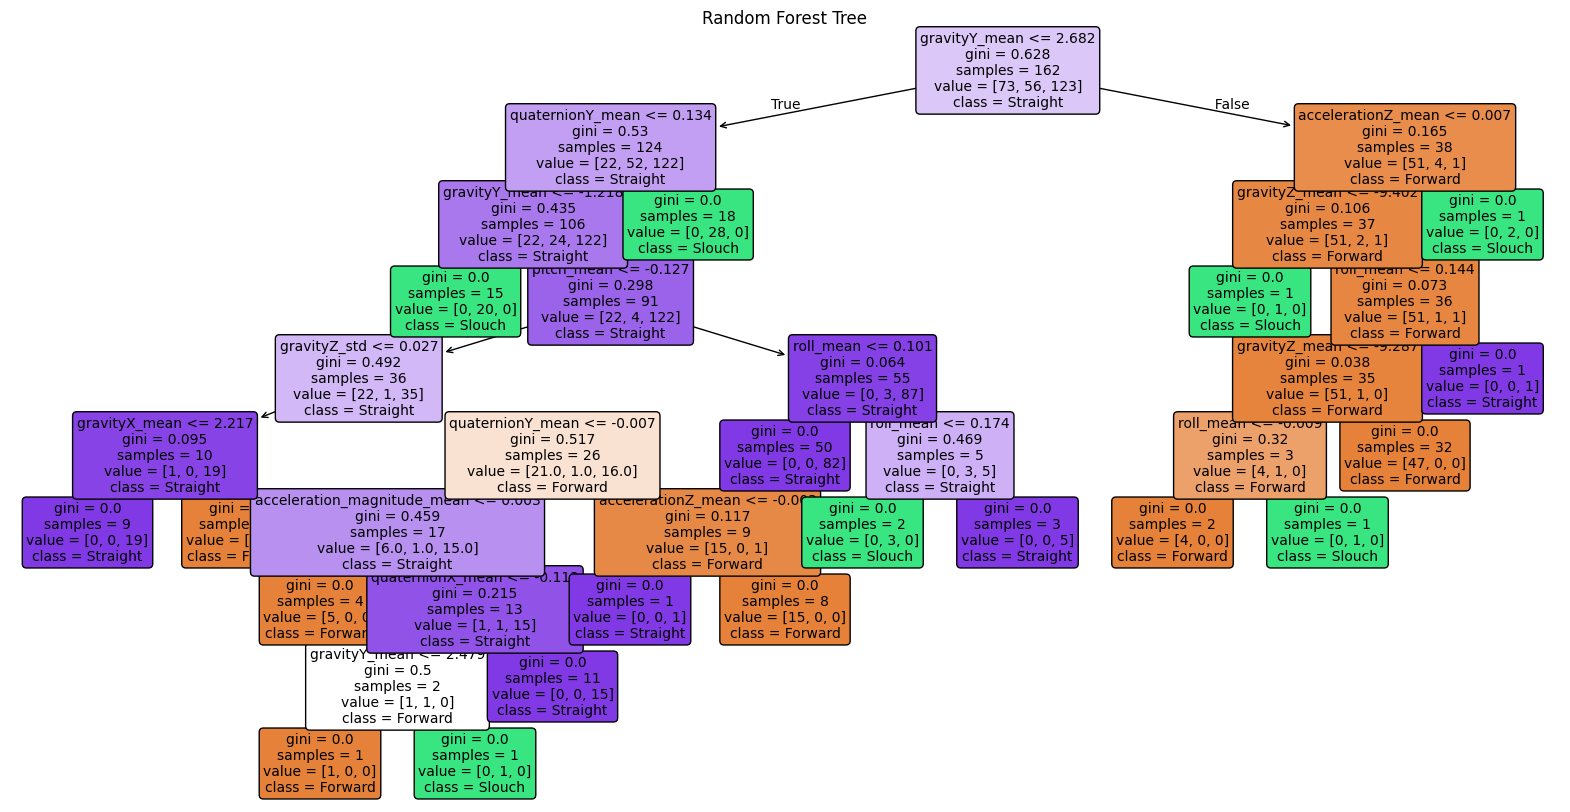

In [121]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import pickle
import numpy as np
from sklearn.tree import plot_tree

# Load the data
data = pd.read_csv('./Data/all_data.csv')

# Separate features and target
X = data.drop('activity', axis=1)
y = data['activity']

# Create the random forest classifier
clf = RandomForestClassifier(random_state=42)

# Fit the classifier to get feature importances
clf.fit(X, y)
feature_importances = clf.feature_importances_
indices = np.argsort(feature_importances)[::-1]

# Select the top N important features (e.g., top 10)
N = 10
important_features = X.columns[indices[:N]]
X_important = X[important_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_important, y, test_size=0.3, random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 6, 7, 10]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_clf = grid_search.best_estimator_

# Train the best estimator on the training data
best_clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_clf.predict(X_test)

# Save the trained model using pickle
with open('best_random_forest_model.pkl', 'wb') as file:
    pickle.dump(best_clf, file)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print evaluation metrics
print(f'Best Parameters: {best_params}')
print(f'Test Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_clf.classes_)
disp.plot()
plt.show()

# Display feature importance
print("Top important features:")
for i in range(N):
    print(f"{important_features[i]}: {feature_importances[indices[i]]}")

# Plot top N feature importances
plt.figure(figsize=(10, 6))
plt.title("Top Feature Importances")
plt.bar(range(N), feature_importances[indices[:N]], align="center")
plt.xticks(range(N), important_features, rotation=90)
plt.xlim([-1, N])
plt.show()

# Plot all feature importances
plt.figure(figsize=(10, 6))
plt.title("All Feature Importances")
plt.bar(range(len(feature_importances)), feature_importances[indices], align="center")
plt.xticks(range(len(feature_importances)), X.columns[indices], rotation=90)
plt.xlim([-1, len(feature_importances)])
plt.show()

# Visualize one of the trees in the forest
estimator = best_clf.estimators_[0]
plt.figure(figsize=(20, 10))
plot_tree(estimator, feature_names=important_features, class_names=best_clf.classes_, filled=True, rounded=True, fontsize=10)
plt.title('Random Forest Tree')
plt.show()

Feature Set: acceleration
Best Parameters: {'max_depth': 20, 'n_estimators': 150}
Test Accuracy: 0.8611111111111112
Confusion Matrix:
[[27  1  3]
 [ 4 23  5]
 [ 1  1 43]]
Classification Report:
              precision    recall  f1-score   support

     Forward       0.84      0.87      0.86        31
      Slouch       0.92      0.72      0.81        32
    Straight       0.84      0.96      0.90        45

    accuracy                           0.86       108
   macro avg       0.87      0.85      0.85       108
weighted avg       0.87      0.86      0.86       108



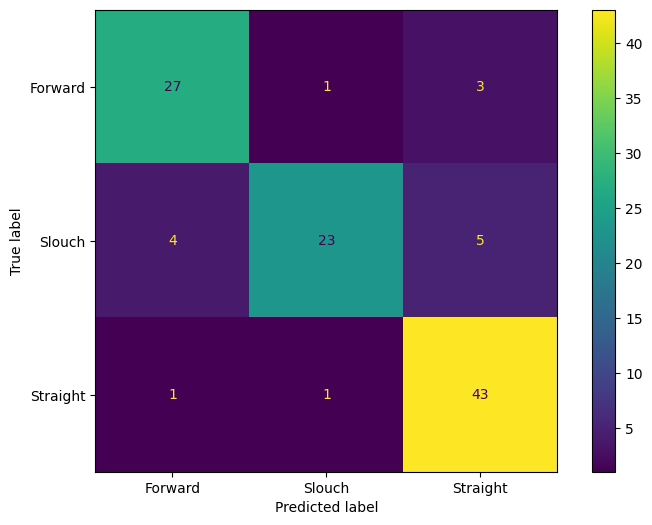

Feature Set: rotation
Best Parameters: {'max_depth': 10, 'n_estimators': 150}
Test Accuracy: 0.5833333333333334
Confusion Matrix:
[[14  4 13]
 [ 7 15 10]
 [ 7  4 34]]
Classification Report:
              precision    recall  f1-score   support

     Forward       0.50      0.45      0.47        31
      Slouch       0.65      0.47      0.55        32
    Straight       0.60      0.76      0.67        45

    accuracy                           0.58       108
   macro avg       0.58      0.56      0.56       108
weighted avg       0.59      0.58      0.58       108



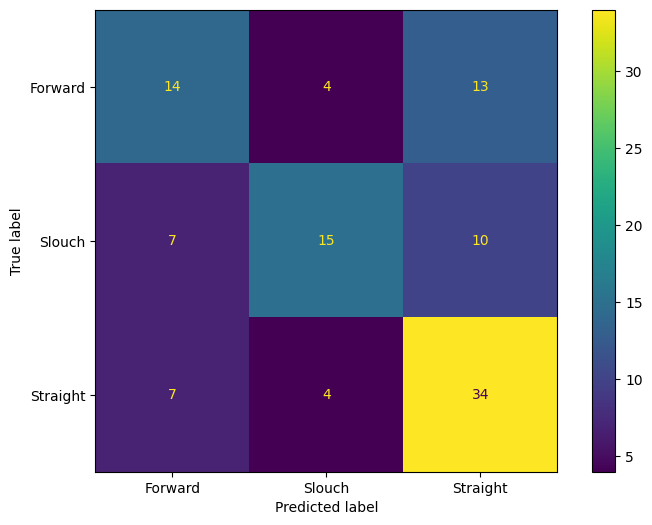

Feature Set: orientation
Best Parameters: {'max_depth': 20, 'n_estimators': 100}
Test Accuracy: 0.9351851851851852
Confusion Matrix:
[[31  0  0]
 [ 4 26  2]
 [ 1  0 44]]
Classification Report:
              precision    recall  f1-score   support

     Forward       0.86      1.00      0.93        31
      Slouch       1.00      0.81      0.90        32
    Straight       0.96      0.98      0.97        45

    accuracy                           0.94       108
   macro avg       0.94      0.93      0.93       108
weighted avg       0.94      0.94      0.93       108



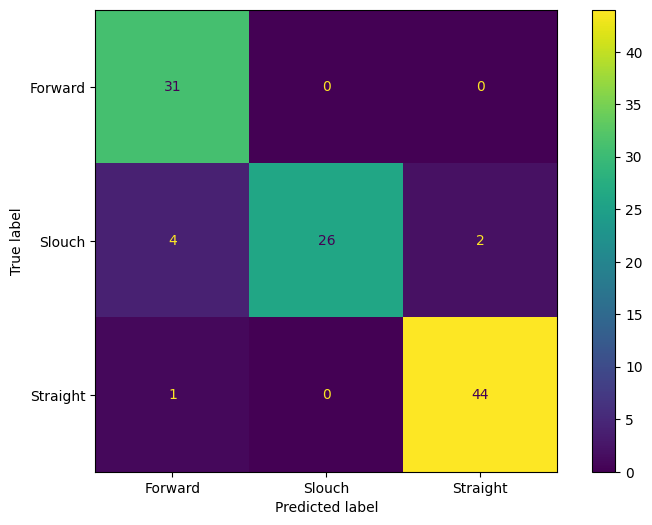

Feature Set: quaternion
Best Parameters: {'max_depth': 10, 'n_estimators': 50}
Test Accuracy: 0.9166666666666666
Confusion Matrix:
[[29  0  2]
 [ 3 26  3]
 [ 1  0 44]]
Classification Report:
              precision    recall  f1-score   support

     Forward       0.88      0.94      0.91        31
      Slouch       1.00      0.81      0.90        32
    Straight       0.90      0.98      0.94        45

    accuracy                           0.92       108
   macro avg       0.93      0.91      0.91       108
weighted avg       0.92      0.92      0.92       108



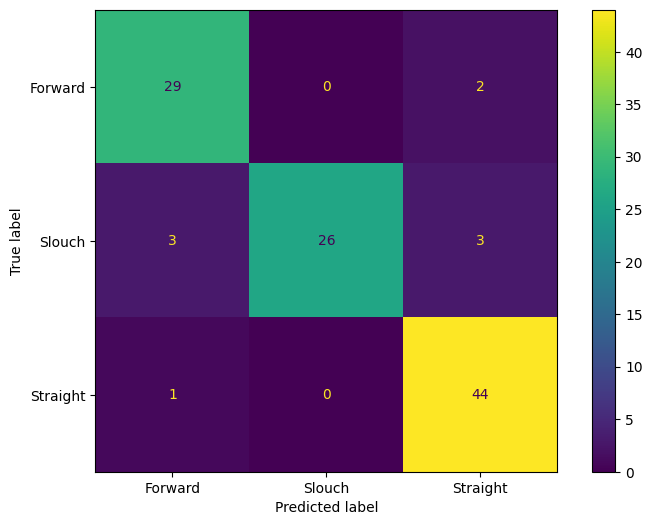

Feature Set: gravity
Best Parameters: {'max_depth': 10, 'n_estimators': 100}
Test Accuracy: 0.9444444444444444
Confusion Matrix:
[[31  0  0]
 [ 4 26  2]
 [ 0  0 45]]
Classification Report:
              precision    recall  f1-score   support

     Forward       0.89      1.00      0.94        31
      Slouch       1.00      0.81      0.90        32
    Straight       0.96      1.00      0.98        45

    accuracy                           0.94       108
   macro avg       0.95      0.94      0.94       108
weighted avg       0.95      0.94      0.94       108



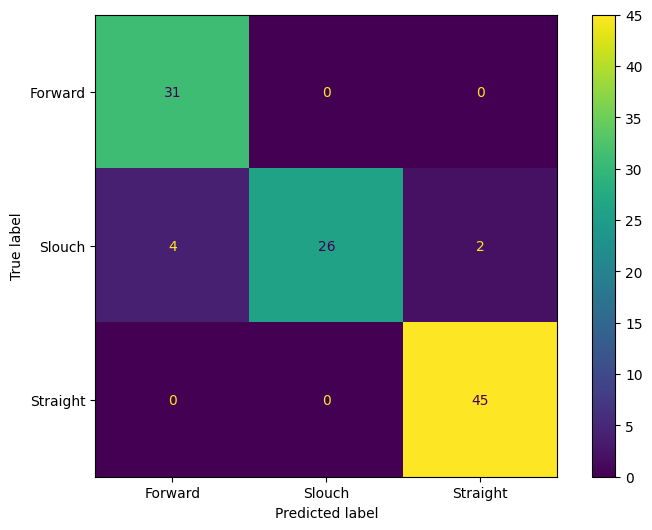

In [122]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import pickle
import numpy as np

# Load the data
data = pd.read_csv('./Data/all_data.csv')

# Define feature sets
acceleration_features = ['acceleration_magnitude_mean', 'acceleration_magnitude_std', 'accelerationX_mean', 'accelerationX_std', 'accelerationY_mean', 'accelerationY_std', 'accelerationZ_mean', 'accelerationZ_std']
rotation_features = ['rotationRateX_mean', 'rotationRateX_std', 'rotationRateY_mean', 'rotationRateY_std', 'rotationRateZ_mean', 'rotationRateZ_std']
orientation_features = ['pitch_mean', 'pitch_std', 'roll_mean', 'roll_std', 'yaw_mean', 'yaw_std']
quaternion_features = ['quaternionX_mean', 'quaternionX_std', 'quaternionY_mean', 'quaternionY_std', 'quaternionZ_mean', 'quaternionZ_std', 'quaternionW_mean', 'quaternionW_std']
gravity_features = ['gravityX_mean', 'gravityX_std', 'gravityY_mean', 'gravityY_std', 'gravityZ_mean', 'gravityZ_std']

# Define a function to train and evaluate a random forest
def train_evaluate_rf(features, feature_set_name):
    X = data[features]
    y = data['activity']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Define the parameter grid
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [5, 10, 20, 30]
    }

    # Create the random forest classifier
    clf = RandomForestClassifier(random_state=42)

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Get the best parameters and the best estimator
    best_params = grid_search.best_params_
    best_clf = grid_search.best_estimator_

    # Train the best estimator on the training data
    best_clf.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = best_clf.predict(X_test)

    # Save the trained model using pickle
    with open(f'best_random_forest_model_{feature_set_name}.pkl', 'wb') as file:
        pickle.dump(best_clf, file)

    # Evaluate the classifier
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    # Print evaluation metrics
    print(f'Feature Set: {feature_set_name}')
    print(f'Best Parameters: {best_params}')
    print(f'Test Accuracy: {accuracy}')
    print('Confusion Matrix:')
    print(conf_matrix)
    print('Classification Report:')
    print(class_report)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_clf.classes_)
    disp.plot()
    plt.show()

# Train and evaluate random forests for each feature set
train_evaluate_rf(acceleration_features, 'acceleration')
train_evaluate_rf(rotation_features, 'rotation')
train_evaluate_rf(orientation_features, 'orientation')
train_evaluate_rf(quaternion_features, 'quaternion')
train_evaluate_rf(gravity_features, 'gravity')